# SATO Customer Churn

## Naive Bayes | Cross-Validation
---
![](banner_telecom.png)

In [7]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)
options(repr.matrix.max.rows=674)
options(repr.matrix.max.cols=200)
update_geom_defaults("point", list(size=1)) 

ERROR: Error in library(dummies): there is no package called ‘dummies’


## Situation

A major wireless telecom operator in South Asia is concerned about the impact of customer churn on its profit, and is considering various intervention strategies.

* **Role:** Vice President of Customer Service. 
* **Business Decision:** Which intervention strategy to implement and how much to invest in it?
* **Approach:** Compare the effectiveness of various intervention strategies to reduce customer churn, including proactive intervention for customers selected at random and for customers predicted to be at risk. 

* **Dataset:**  MCS: Multiple Classifier System to Predict the Churners in the Telecom Industry (https://www.kaggle.com/mahreen/sato2015) 
  * South Asian Telecom Operator (SATO) data set is real life data collected from a major wireless telecom operator in South Asia. Most of the variables in the data set are associated with call detail records (CDR), billing, and personal information. It contains 2000 subscribers. All of these subscribers were not contract-based and had a monthly based subscription. The subscriber data was extracted from the time interval of two months August 2015 and September 2015. 

  * The dataset includes these variables:
    * **Aggregate of Total Revenue:** The overall monthly revenue earned in Rupees by the carrier in the months August & September 2015.
    * **Aggregate of SMS Revenue:** The revenue earned through the SMS service used by the subscriber.
    * **Aggregate of Data Revenue:** The revenue earned through the Data service used by the subscriber.
    * **Aggregate of Off Net Revenue:** The revenue earned by the calls etc. made to the off-network (not the same network as the subscriber) customers by the carrier’s present subscriber.
    * **Aggregate of On Net Revenue:** The revenue earned by the calls etc. made to the on-network (on the same network as the subscriber) customers by the carrier’s present subscriber. 
    * **Network Age:** The time passed since the subscriber started using the services of the carrier.
    * **User Type:** This detail helps in knowing if the user is subscribed to a 2G or 3G service.
    * **Aggregate of Complaint Count:** The number of complaints made by the subscribers.
    * **Favorite Other Network:** This information can certainly have a huge impact on churn ratio as it gives the information about which other network or operator the subscribers makes the most of the calls to and thus might influence the customer to move to that network to save money.
    * **Aggregate of Data Volume:** The volume of the data service used by the subscriber.

## Business Model

Estimate value of an active customer and lost value of a churned customer.  Estimate churn rate based on another telco.  Make reasonable assumptions about other business parameters, including total number of customers, intervention cost, and save rate (fraction of interventions to would-be churned customers that result in keeping them active).

### Influence Diagram

<img src="business-model_sato.jpg" align=left width=850 />

### Business Parameters

In [2]:
customers=1000000 # assumption
churn_rate=0.143 # based on another telco
intervention_cost=500 # rupees per year, assumption
save_rate=0.25 # assumption
data.frame(customers, churn_rate, intervention_cost, save_rate)

customers,churn_rate,intervention_cost,save_rate
1000000,0.143,500,0.25


### Sensitivity Analysis

The following are alternative business parameter values for further sensitivity analysis.

In [3]:
# save_rate = 0.15
# save_rate = 0.25
# save_rate = 0.40

# intervention_cost = 250
# intervention_cost = 500
# intervention_cost = 1000

## Data

In [6]:
data.raw = read.csv("SATO.csv", na.strings="")
output_size(data.raw)
data.raw[1:10,]

ERROR: Error in output_size(data.raw): не могу найти функцию "output_size"


## Analysis

### Customer Value

Active customer value & churned customer value ...

In [5]:
active = data.raw$Class=="Active"
churned = data.raw$Class=="Churned"
active_value  = mean(data.raw$Aggregate_Total_Rev[active] * 6) # rupees per year
churned_value = mean(data.raw$Aggregate_Total_Rev[churned] * 6) # rupees per year

data.frame(customers, active_value, churned_value, churn_rate, intervention_cost, save_rate)

customers,active_value,churned_value,churn_rate,intervention_cost,save_rate
1000000,6901.378,3958.863,0.143,500,0.25


### Baseline

Determine what profit would be if no intervention is attempted.

In [6]:
profit.churned = 0
profit.active = customers * (1-churn_rate) * active_value

profit.baseline = profit.active + profit.churned

data.frame(profit.churned, profit.active, profit.baseline)

profit.churned,profit.active,profit.baseline
0,5914481245,5914481245


### Prepare Data

#### Unbalance data

Note that the raw data is balanced: equal numbers of active and churned customers.  Unbalance the data by oversampling active customers so that ratio of active to churned customers aligns with assumed churn rate.

In [7]:
which.churned = which(data.raw$Class=="Churned")
which.active  = which(data.raw$Class=="Active")

n.churned = length(which.churned)
n.active  = length(which.churned)

data.frame(n.churned, n.active)

n.churned,n.active
1000,1000


In [8]:
n.active.target = round(n.churned * (1-churn_rate) / churn_rate)

data.frame(n.active.target)

n.active.target
5993


In [9]:
set.seed(12345)
which.active.target = sample(which.active, n.active.target, replace=TRUE)

data = data.raw[c(which.active.target, which.churned),]

layout(size(data), fmt(churn_rate), fmt(length(which(data$Class=="Churned"))/nrow(data), "churn_rate.calc"))

observations 
 variables 
 
 
 
 
 6993 
 14 
 
 
 
 
 
 churn_rate 
 
 
 
 
 0.143 
 
 
 
 
 
 churn_rate.calc 
 
 
 
 
 0.1430001

#### Create 5 folds

In [10]:
set.seed(12345)
fold = createFolds(data$Class, k=5)

data.train.1 = data[setdiff(1:nrow(data), fold$Fold1),]
data.train.2 = data[setdiff(1:nrow(data), fold$Fold2),]
data.train.3 = data[setdiff(1:nrow(data), fold$Fold3),]
data.train.4 = data[setdiff(1:nrow(data), fold$Fold4),]
data.train.5 = data[setdiff(1:nrow(data), fold$Fold5),]

data.test.1 = data[fold$Fold1,]
data.test.2 = data[fold$Fold2,]
data.test.3 = data[fold$Fold3,]
data.test.4 = data[fold$Fold4,]
data.test.5 = data[fold$Fold5,]

### Intervene with Randomly Selected 10% of Customers

Consider the effect on profit of a predictive model that selects 10% of customers at random (only some may be at risk of churn) for intervention (necessarily for would-be churned customers and unnecessarily for active customers).  Evaluate using 5-fold cross-validation. 

#### Probabilities, predictions, & confusion matrix

##### Fold 1: Probabilities, predictions, & confusion matrix

In [11]:
set.seed(12345)
model.1 = random_intervention(Class ~ ., data.train.1, intervention_rate=0.10)
prob.1 = predict(model.1, data.test.1)
prob.1[1:10,]

Active,Churned
1,0
1,0
1,0
1,0
1,0
1,0
1,0
1,0
1,0
0,1


In [12]:
prediction.1 = as.class(prob.1, class="Active", cutoff=0.5)
prediction.1[1:35]

[1] Active  Active  Active  Active  Active  Active  Active  Active  Active 
[10] Churned Active  Active  Active  Active  Active  Active  Active  Active 
[19] Active  Churned Active  Active  Churned Active  Active  Active  Active 
[28] Active  Active  Active  Active  Active  Active  Active  Active 
Levels: Active Churned

In [13]:
CM.1 = confusionMatrix(prediction.1, data.test.1$Class)$table
fmt.cm(CM.1)

,Active,Churned
Active,1082,178
Churned,116,22


In [14]:
cm.1 = CM.1 / sum(CM.1)
fmt.cm(cm.1)

,Active,Churned
Active,0.7739628,0.1273247
Churned,0.0829757,0.0157368


##### Folds 2, 3, 4, 5:  Probabilities, predictions, & confusion matrices

In [15]:
set.seed(123456)

model.2 = random_intervention(Class ~ ., data.train.2, intervention_rate=0.10)
prob.2 = predict(model.2, data.test.2)
prediction.2 = as.class(prob.2, class="Active", cutoff=0.5)
CM.2 = confusionMatrix(prediction.2, data.test.2$Class)$table
cm.2 = CM.2 / sum(CM.2)

model.3 = random_intervention(Class ~ ., data.train.3, intervention_rate=0.10)
prob.3 = predict(model.3, data.test.3)
prediction.3 = as.class(prob.3, class="Active", cutoff=0.5)
CM.3 = confusionMatrix(prediction.3, data.test.3$Class)$table
cm.3 = CM.3 / sum(CM.3)

model.4 = random_intervention(Class ~ ., data.train.4, intervention_rate=0.10)
prob.4 = predict(model.4, data.test.4)
prediction.4 = as.class(prob.4, class="Active", cutoff=0.5)
CM.4 = confusionMatrix(prediction.4, data.test.4$Class)$table
cm.4 = CM.4 / sum(CM.4)

model.5 = random_intervention(Class ~ ., data.train.5, intervention_rate=0.10)
prob.5 = predict(model.5, data.test.5)
prediction.5 = as.class(prob.5, class="Active", cutoff=0.5)
CM.5 = confusionMatrix(prediction.5, data.test.5$Class)$table
cm.5 = CM.5 / sum(CM.5)

layout(fmt.cm(cm.2), fmt.cm(cm.3), fmt.cm(cm.4), fmt.cm(cm.5))

,Active,Churned
Active,0.7769836,0.1322373
Churned,0.0800572,0.0107219
,Active,Churned
Active,0.7805575,0.1236598
Churned,0.0764832,0.0192995
,Active,Churned
Active,0.7726948,0.1243746
Churned,0.0843460,0.0185847
,Active,Churned
Active,0.7718169,0.1258941


#### Accuracy

In [16]:
accuracy.1 = cm.1["Active","Active"]+cm.1["Churned","Churned"]
accuracy.2 = cm.2["Active","Active"]+cm.2["Churned","Churned"]
accuracy.3 = cm.3["Active","Active"]+cm.3["Churned","Churned"]
accuracy.4 = cm.4["Active","Active"]+cm.4["Churned","Churned"]
accuracy.5 = cm.5["Active","Active"]+cm.5["Churned","Churned"]

accuracy.random10 = mean(c(accuracy.1, accuracy.2, accuracy.3, accuracy.4, accuracy.5))
data.frame(accuracy.random10)

accuracy.random10
0.7915052


#### Profit

##### Fold 1: Profit

In [17]:
active_active.1   = round(customers * (1-churn_rate) * cm.1["Active","Active"]/sum(cm.1[,"Active"]))
active_churned.1  = round(customers * churn_rate * cm.1["Active","Churned"]/sum(cm.1[,"Churned"]))
churned_active.1  = round(customers * (1-churn_rate) * cm.1["Churned","Active"]/sum(cm.1[,"Active"]))
churned_churned.1 = round(customers * churn_rate * cm.1["Churned","Churned"]/sum(cm.1[,"Churned"]))

data.frame(active_active.1, active_churned.1, churned_active.1, churned_churned.1)

active_active.1,active_churned.1,churned_active.1,churned_churned.1
774018,127270,82982,15730


In [18]:
profit.churned_churned.1 = ((churned_churned.1 * save_rate * churned_value) - (churned_churned.1 * intervention_cost))
profit.active_churned.1 = 0
profit.churned_active.1 = (churned_active.1 * active_value) - (churned_active.1 * intervention_cost)
profit.active_active.1 = (active_active.1 * active_value)
profit.1 = profit.churned_churned.1 + profit.active_churned.1 + profit.churned_active.1 + profit.active_active.1

data.frame(profit.churned_churned.1, profit.active_churned.1, profit.churned_active.1, profit.active_active.1, profit.1)

profit.churned_churned.1,profit.active_churned.1,profit.churned_active.1,profit.active_active.1,profit.1
7703228,0,531199178,5341791067,5880693473


##### Fold 2: Profit

In [19]:
active_active.2   = round(customers * (1-churn_rate) * cm.2["Active","Active"]/sum(cm.2[,"Active"]))
active_churned.2  = round(customers * churn_rate * cm.2["Active","Churned"]/sum(cm.2[,"Churned"]))
churned_active.2  = round(customers * (1-churn_rate) * cm.2["Churned","Active"]/sum(cm.2[,"Active"]))
churned_churned.2 = round(customers * churn_rate * cm.2["Churned","Churned"]/sum(cm.2[,"Churned"]))

profit.churned_churned.2 = ((churned_churned.2 * save_rate * churned_value) - (churned_churned.2 * intervention_cost))
profit.active_churned.2 = 0
profit.churned_active.2 = (churned_active.2 * active_value) - (churned_active.2 * intervention_cost)
profit.active_active.2 = (active_active.2 * active_value)
profit.2 = profit.churned_churned.2 + profit.active_churned.2 + profit.churned_active.2 + profit.active_active.2

data.frame(profit.churned_churned.2, profit.active_churned.2, profit.churned_active.2, profit.active_active.2, profit.2)

profit.churned_churned.2,profit.active_churned.2,profit.churned_active.2,profit.active_active.2,profit.2
5252201,0,512449541,5362005204,5879706946


##### Fold 3: Profit

In [20]:
active_active.3   = round(customers * (1-churn_rate) * cm.3["Active","Active"]/sum(cm.3[,"Active"]))
active_churned.3  = round(customers * churn_rate * cm.3["Active","Churned"]/sum(cm.3[,"Churned"]))
churned_active.3  = round(customers * (1-churn_rate) * cm.3["Churned","Active"]/sum(cm.3[,"Active"]))
churned_churned.3 = round(customers * churn_rate * cm.3["Churned","Churned"]/sum(cm.3[,"Churned"]))

profit.churned_churned.3 = ((churned_churned.3 * save_rate * churned_value) - (churned_churned.3 * intervention_cost))
profit.active_churned.3 = 0
profit.churned_active.3 = (churned_active.3 * active_value) - (churned_active.3 * intervention_cost)
profit.active_active.3 = (active_active.3 * active_value)
profit.3 = profit.churned_churned.3 + profit.active_churned.3 + profit.churned_active.3 + profit.active_active.3

data.frame(profit.churned_churned.3, profit.active_churned.3, profit.churned_active.3, profit.active_active.3, profit.3)

profit.churned_churned.3,profit.active_churned.3,profit.churned_active.3,profit.active_active.3,profit.3
9453962,0,489577416,5386663829,5885695207


##### Fold 4: Profit

In [21]:
active_active.4   = round(customers * (1-churn_rate) * cm.4["Active","Active"]/sum(cm.4[,"Active"]))
active_churned.4  = round(customers * churn_rate * cm.4["Active","Churned"]/sum(cm.4[,"Churned"]))
churned_active.4  = round(customers * (1-churn_rate) * cm.4["Churned","Active"]/sum(cm.4[,"Active"]))
churned_churned.4 = round(customers * churn_rate * cm.4["Churned","Churned"]/sum(cm.4[,"Churned"]))

profit.churned_churned.4 = ((churned_churned.4 * save_rate * churned_value) - (churned_churned.4 * intervention_cost))
profit.active_churned.4 = 0
profit.churned_active.4 = (churned_active.4 * active_value) - (churned_active.4 * intervention_cost)
profit.active_active.4 = (active_active.4 * active_value)
profit.4 = profit.churned_churned.4 + profit.active_churned.4 + profit.churned_active.4 + profit.active_active.4

data.frame(profit.churned_churned.4, profit.active_churned.4, profit.churned_active.4, profit.active_active.4, profit.4)

profit.churned_churned.4,profit.active_churned.4,profit.churned_active.4,profit.active_active.4,profit.4
9103815,0,539905053,5332405192,5881414060


##### Fold 5: Profit

In [22]:
active_active.5   = round(customers * (1-churn_rate) * cm.5["Active","Active"]/sum(cm.5[,"Active"]))
active_churned.5  = round(customers * churn_rate * cm.5["Active","Churned"]/sum(cm.5[,"Churned"]))
churned_active.5  = round(customers * (1-churn_rate) * cm.5["Churned","Active"]/sum(cm.5[,"Active"]))
churned_churned.5 = round(customers * churn_rate * cm.5["Churned","Churned"]/sum(cm.5[,"Churned"]))

profit.churned_churned.5 = ((churned_churned.5 * save_rate * churned_value) - (churned_churned.5 * intervention_cost))
profit.active_churned.5 = 0
profit.churned_active.5 = (churned_active.5 * active_value) - (churned_active.5 * intervention_cost)
profit.active_active.5 = (active_active.5 * active_value)
profit.5 = profit.churned_churned.5 + profit.active_churned.5 + profit.churned_active.5 + profit.active_active.5

data.frame(profit.churned_churned.5, profit.active_churned.5, profit.churned_active.5, profit.active_active.5, profit.5)

profit.churned_churned.5,profit.active_churned.5,profit.churned_active.5,profit.active_active.5,profit.5
8403522,0,544936536,5326980709,5880320767


##### Average Profit

In [23]:
profit.random10 = mean(c(profit.1, profit.2, profit.3, profit.4, profit.5))
data.frame(profit.random10)

profit.random10
5881566091


### Intervene with Randomly Selected 20% of Customers

Consider the effect on profit of a predictive model that selects 20% of customers at random (only some may be at risk of churn) for intervention (necessarily for would-be churned customers and unnecessarily for active customers).  Evaluate using 5-fold cross-validation. 

#### Probabilities, predictions, & confusion matrices

Note that correct prediction of active observations is high because most of the observations in the test data are active.  In constrast, correct prediction of churned observations is 3 times lower than incorrect prediction of churned observations.   

In [24]:
set.seed(12345)

model.1 = random_intervention(Class ~ ., data.train.1, intervention_rate=0.20)
prob.1 = predict(model.1, data.test.1)
prediction.1 = as.class(prob.1, class="Active", cutoff=0.5)
CM.1 = confusionMatrix(prediction.1, data.test.1$Class)$table
cm.1 = CM.1 / sum(CM.1)

model.2 = random_intervention(Class ~ ., data.train.2, intervention_rate=0.20)
prob.2 = predict(model.2, data.test.2)
prediction.2 = as.class(prob.2, class="Active", cutoff=0.5)
CM.2 = confusionMatrix(prediction.2, data.test.2$Class)$table
cm.2 = CM.2 / sum(CM.2)

model.3 = random_intervention(Class ~ ., data.train.3, intervention_rate=0.20)
prob.3 = predict(model.3, data.test.3)
prediction.3 = as.class(prob.3, class="Active", cutoff=0.5)
CM.3 = confusionMatrix(prediction.3, data.test.3$Class)$table
cm.3 = CM.3 / sum(CM.3)

model.4 = random_intervention(Class ~ ., data.train.4, intervention_rate=0.20)
prob.4 = predict(model.4, data.test.4)
prediction.4 = as.class(prob.4, class="Active", cutoff=0.5)
CM.4 = confusionMatrix(prediction.4, data.test.4$Class)$table
cm.4 = CM.4 / sum(CM.4)

model.5 = random_intervention(Class ~ ., data.train.5, intervention_rate=0.20)
prob.5 = predict(model.5, data.test.5)
prediction.5 = as.class(prob.5, class="Active", cutoff=0.5)
CM.5 = confusionMatrix(prediction.5, data.test.5$Class)$table
cm.5 = CM.5 / sum(CM.5)

layout(fmt.cm(cm.1), fmt.cm(cm.2), fmt.cm(cm.3))
layout(fmt.cm(cm.4), fmt.cm(cm.5))

,Active,Churned
Active,0.6859800,0.1087268
Churned,0.1709585,0.0343348
,Active,Churned
Active,0.6754825,0.1193710
Churned,0.1815583,0.0235883
,Active,Churned
Active,0.6876340,0.1179414
Churned,0.1694067,0.0250179


,Active,Churned
Active,0.6940672,0.1136526
Churned,0.1629736,0.0293066
,Active,Churned
Active,0.6931330,0.1158798
Churned,0.1638054,0.0271817


#### Accuracy

In [25]:
accuracy.1 = cm.1["Active","Active"]+cm.1["Churned","Churned"]
accuracy.2 = cm.2["Active","Active"]+cm.2["Churned","Churned"]
accuracy.3 = cm.3["Active","Active"]+cm.3["Churned","Churned"]
accuracy.4 = cm.4["Active","Active"]+cm.4["Churned","Churned"]
accuracy.5 = cm.5["Active","Active"]+cm.5["Churned","Churned"]

accuracy.random20 = mean(c(accuracy.1, accuracy.2, accuracy.3, accuracy.4, accuracy.5))
data.frame(accuracy.random20)

accuracy.random20
0.7151452


#### Profit

In [26]:
active_active.1   = round(customers * (1-churn_rate) * cm.1["Active","Active"]/sum(cm.1[,"Active"]))
active_churned.1  = round(customers * churn_rate * cm.1["Active","Churned"]/sum(cm.1[,"Churned"]))
churned_active.1  = round(customers * (1-churn_rate) * cm.1["Churned","Active"]/sum(cm.1[,"Active"]))
churned_churned.1 = round(customers * churn_rate * cm.1["Churned","Churned"]/sum(cm.1[,"Churned"]))

profit.churned_churned.1 = ((churned_churned.1 * save_rate * churned_value) - (churned_churned.1 * intervention_cost))
profit.active_churned.1 = 0
profit.churned_active.1 = (churned_active.1 * active_value) - (churned_active.1 * intervention_cost)
profit.active_active.1 = (active_active.1 * active_value)
profit.1 = profit.churned_churned.1 + profit.active_churned.1 + profit.churned_active.1 + profit.active_active.1


active_active.2   = round(customers * (1-churn_rate) * cm.2["Active","Active"]/sum(cm.2[,"Active"]))
active_churned.2  = round(customers * churn_rate * cm.2["Active","Churned"]/sum(cm.2[,"Churned"]))
churned_active.2  = round(customers * (1-churn_rate) * cm.2["Churned","Active"]/sum(cm.2[,"Active"]))
churned_churned.2 = round(customers * churn_rate * cm.2["Churned","Churned"]/sum(cm.2[,"Churned"]))

profit.churned_churned.2 = ((churned_churned.2 * save_rate * churned_value) - (churned_churned.2 * intervention_cost))
profit.active_churned.2 = 0
profit.churned_active.2 = (churned_active.2 * active_value) - (churned_active.2 * intervention_cost)
profit.active_active.2 = (active_active.2 * active_value)
profit.2 = profit.churned_churned.2 + profit.active_churned.2 + profit.churned_active.2 + profit.active_active.2


active_active.3   = round(customers * (1-churn_rate) * cm.3["Active","Active"]/sum(cm.3[,"Active"]))
active_churned.3  = round(customers * churn_rate * cm.3["Active","Churned"]/sum(cm.3[,"Churned"]))
churned_active.3  = round(customers * (1-churn_rate) * cm.3["Churned","Active"]/sum(cm.3[,"Active"]))
churned_churned.3 = round(customers * churn_rate * cm.3["Churned","Churned"]/sum(cm.3[,"Churned"]))

profit.churned_churned.3 = ((churned_churned.3 * save_rate * churned_value) - (churned_churned.3 * intervention_cost))
profit.active_churned.3 = 0
profit.churned_active.3 = (churned_active.3 * active_value) - (churned_active.3 * intervention_cost)
profit.active_active.3 = (active_active.3 * active_value)
profit.3 = profit.churned_churned.3 + profit.active_churned.3 + profit.churned_active.3 + profit.active_active.3


active_active.4   = round(customers * (1-churn_rate) * cm.4["Active","Active"]/sum(cm.4[,"Active"]))
active_churned.4  = round(customers * churn_rate * cm.4["Active","Churned"]/sum(cm.4[,"Churned"]))
churned_active.4  = round(customers * (1-churn_rate) * cm.4["Churned","Active"]/sum(cm.4[,"Active"]))
churned_churned.4 = round(customers * churn_rate * cm.4["Churned","Churned"]/sum(cm.4[,"Churned"]))

profit.churned_churned.4 = ((churned_churned.4 * save_rate * churned_value) - (churned_churned.4 * intervention_cost))
profit.active_churned.4 = 0
profit.churned_active.4 = (churned_active.4 * active_value) - (churned_active.4 * intervention_cost)
profit.active_active.4 = (active_active.4 * active_value)
profit.4 = profit.churned_churned.4 + profit.active_churned.4 + profit.churned_active.4 + profit.active_active.4


active_active.5   = round(customers * (1-churn_rate) * cm.5["Active","Active"]/sum(cm.5[,"Active"]))
active_churned.5  = round(customers * churn_rate * cm.5["Active","Churned"]/sum(cm.5[,"Churned"]))
churned_active.5  = round(customers * (1-churn_rate) * cm.5["Churned","Active"]/sum(cm.5[,"Active"]))
churned_churned.5 = round(customers * churn_rate * cm.5["Churned","Churned"]/sum(cm.5[,"Churned"]))

profit.churned_churned.5 = ((churned_churned.5 * save_rate * churned_value) - (churned_churned.5 * intervention_cost))
profit.active_churned.5 = 0
profit.churned_active.5 = (churned_active.5 * active_value) - (churned_active.5 * intervention_cost)
profit.active_active.5 = (active_active.5 * active_value)
profit.5 = profit.churned_churned.5 + profit.active_churned.5 + profit.churned_active.5 + profit.active_active.5


profit.random20 = mean(c(profit.1, profit.2, profit.3, profit.4, profit.5))


data.frame(fold=1:5,
           profit.active_active=  c(profit.active_active.1,   profit.active_active.2,   profit.active_active.3,   profit.active_active.4,   profit.active_active.5),
           profit.active_churned= c(profit.active_churned.1,  profit.active_churned.2,  profit.active_churned.3,  profit.active_churned.4,  profit.active_churned.5),
           profit.churned_active= c(profit.churned_active.1,  profit.churned_active.2,  profit.churned_active.3,  profit.churned_active.4,  profit.churned_active.5),
           profit.churned_churned=c(profit.churned_churned.1, profit.churned_churned.2, profit.churned_churned.3, profit.churned_churned.4, profit.churned_churned.5),
           profit=c(profit.1, profit.2, profit.3, profit.4, profit.5))

data.frame(profit.random20)

fold,profit.active_active,profit.active_churned,profit.churned_active,profit.churned_churned,profit
1,4734545687,0,1094450058,16807044,5845802789
2,4661536006,0,1162170239,11554843,5835261088
3,4745394654,0,1084387091,12255136,5842036881
4,4789791221,0,1043207024,14356017,5847354262
5,4783918148,0,1048654597,13305576,5845878321


profit.random20
5843266668


### Intervene with Predicted At-Risk Customers

Consider the effect on profit of a naive Bayes predictive model that selects customers (only some may be at risk of churn) for intervention (necessarily for would-be churned customers and unnecessarily for active customers).  Evaluate using 5-fold cross-validation.

#### Fold 1: Model 

In [27]:
model.1 = naiveBayes(Class ~ ., data.train.1)
model.1


Naive Bayes Classifier for Discrete Predictors

Call:
naiveBayes.default(x = X, y = Y, laplace = laplace)

A-priori probabilities:
Y
   Active   Churned 
0.8570152 0.1429848 

Conditional probabilities:
         network_age
Y             [,1]     [,2]
  Active  1698.747 1383.675
  Churned 1248.720 1153.039

         Aggregate_Total_Rev
Y             [,1]     [,2]
  Active  1157.102 1157.077
  Churned  688.034 1268.333

         Aggregate_SMS_Rev
Y             [,1]     [,2]
  Active  26.74145 56.16296
  Churned 34.84649 57.77641

         Aggregate_Data_Rev
Y             [,1]     [,2]
  Active  55.47275 126.9113
  Churned 59.52698 331.5728

         Aggregate_Data_Vol
Y            [,1]     [,2]
  Active  4114314 10916942
  Churned 1313707  4001877

         Aggregate_Calls
Y             [,1]     [,2]
  Active  346.1541 453.1232
  Churned 147.6400 246.8455

         Aggregate_ONNET_REV
Y             [,1]     [,2]
  Active  8989.376 16367.30
  Churned 5894.991 17970.51

         Aggregat

#### Inspect some internals of the model

In [28]:
data.frame(Class=c("Active","Churned"),
           likelihood.network_age.gaussian_mean = c(mean(data.train.1$network_age[data.train.1$Class=="Active"]),
                                                    mean(data.train.1$network_age[data.train.1$Class=="Churned"])),
           likelihood.network_age.gaussian_sd = c(sd(data.train.1$network_age[data.train.1$Class=="Active"]),
                                                  sd(data.train.1$network_age[data.train.1$Class=="Churned"])))

Class,likelihood.network_age.gaussian_mean,likelihood.network_age.gaussian_sd
Active,1698.747,1383.675
Churned,1248.720,1153.039


In [29]:
model.Active = as.data.frame(table(data.train.1$aug_user_type[data.train.1$Class=="Active"]))
model.Active$likelihood = model.Active$Freq / sum(model.Active$Freq)

model.Churned = as.data.frame(table(data.train.1$aug_user_type[data.train.1$Class=="Churned"]))
model.Churned$likelihood = model.Churned$Freq / sum(model.Churned$Freq)

layout(fmt(model.Active, "Active"), fmt(model.Churned, "Churned"))

Var1,Freq,likelihood
2G,826,0.2000969
3G,2485,0.6019864
Other,817,0.1979167
Var1,Freq,likelihood
2G,171,0.2418670
3G,365,0.5162659
Other,171,0.2418670


#### Folds 1: Probabilities 

In [30]:
prob.1 = predict(model.1, data.test.1, type="raw")
prob.1[1:10,]

Active,Churned
0.9994437,0.000556336015
0.7817316,0.218268360881
0.9704236,0.029576357604
0.9180357,0.081964279365
0.9999994,0.000000569189
0.8644693,0.135530657820
0.9999451,0.000054856858
0.7703932,0.229606844459
0.8502242,0.149775832352
0.7348143,0.265185686471


#### Fold 1: Predictions

In [31]:
prediction.1 = as.class(prob.1, class="Active", cutoff=0.5)
prediction.1[1:35]

[1] Active  Active  Active  Active  Active  Active  Active  Active  Active 
[10] Active  Active  Active  Active  Active  Churned Active  Active  Active 
[19] Active  Active  Active  Churned Active  Active  Active  Churned Active 
[28] Active  Churned Active  Active  Active  Active  Active  Churned
Levels: Active Churned

#### Fold 1: Confusion matrix

In [32]:
CM.1 = confusionMatrix(prediction.1, data.test.1$Class)$table
cm.1 = CM.1 / sum(CM.1)
fmt.cm(cm.1)

,Active,Churned
Active,0.7560801,0.0815451
Churned,0.1008584,0.0615165


#### Folds 2, 3, 4, 5:  Models, probabilities, predictions, & confusion matrices

In [33]:
model.2 = naiveBayes(Class ~ ., data.train.2)
prob.2 = predict(model.2, data.test.2, type="raw")
prediction.2 = as.class(prob.2, class="Active", cutoff=0.5)
CM.2 = confusionMatrix(prediction.2, data.test.2$Class)$table
cm.2 = CM.2 / sum(CM.2)

model.3 = naiveBayes(Class ~ ., data.train.3)
prob.3 = predict(model.3, data.test.3, type="raw")
prediction.3 = as.class(prob.3, class="Active", cutoff=0.5)
CM.3 = confusionMatrix(prediction.3, data.test.3$Class)$table
cm.3 = CM.2 / sum(CM.3)

model.4 = naiveBayes(Class ~ ., data.train.4)
prob.4 = predict(model.4, data.test.4, type="raw")
prediction.4 = as.class(prob.4, class="Active", cutoff=0.5)
CM.4 = confusionMatrix(prediction.4, data.test.4$Class)$table
cm.4 = CM.4 / sum(CM.4)

model.5 = naiveBayes(Class ~ ., data.train.5)
prob.5 = predict(model.5, data.test.5, type="raw")
prediction.5 = as.class(prob.5, class="Active", cutoff=0.5)
CM.5 = confusionMatrix(prediction.5, data.test.5$Class)$table
cm.5 = CM.5 / sum(CM.5)

layout(fmt.cm(cm.2), fmt.cm(cm.3), fmt.cm(cm.4), fmt.cm(cm.5))

,Active,Churned
Active,0.7362402,0.0786276
Churned,0.1208006,0.0643317
,Active,Churned
Active,0.7362402,0.0786276
Churned,0.1208006,0.0643317
,Active,Churned
Active,0.6504646,0.0578985
Churned,0.2065761,0.0850608
,Active,Churned
Active,0.7675250,0.0865522


#### Accuracy

In [34]:
accuracy.1 = cm.1["Active","Active"]+cm.1["Churned","Churned"]
accuracy.2 = cm.2["Active","Active"]+cm.2["Churned","Churned"]
accuracy.3 = cm.3["Active","Active"]+cm.3["Churned","Churned"]
accuracy.4 = cm.4["Active","Active"]+cm.4["Churned","Churned"]
accuracy.5 = cm.5["Active","Active"]+cm.5["Churned","Churned"]

accuracy.nb = mean(c(accuracy.1, accuracy.2, accuracy.3, accuracy.4, accuracy.5))
data.frame(accuracy.nb)

accuracy.nb
0.79566


#### Profit

In [35]:
active_active.1   = round(customers * (1-churn_rate) * cm.1["Active","Active"]/sum(cm.1[,"Active"]))
active_churned.1  = round(customers * churn_rate * cm.1["Active","Churned"]/sum(cm.1[,"Churned"]))
churned_active.1  = round(customers * (1-churn_rate) * cm.1["Churned","Active"]/sum(cm.1[,"Active"]))
churned_churned.1 = round(customers * churn_rate * cm.1["Churned","Churned"]/sum(cm.1[,"Churned"]))

profit.churned_churned.1 = ((churned_churned.1 * save_rate * churned_value) - (churned_churned.1 * intervention_cost))
profit.active_churned.1 = 0
profit.churned_active.1 = (churned_active.1 * active_value) - (churned_active.1 * intervention_cost)
profit.active_active.1 = (active_active.1 * active_value)
profit.1 = profit.churned_churned.1 + profit.active_churned.1 + profit.churned_active.1 + profit.active_active.1


active_active.2   = round(customers * (1-churn_rate) * cm.2["Active","Active"]/sum(cm.2[,"Active"]))
active_churned.2  = round(customers * churn_rate * cm.2["Active","Churned"]/sum(cm.2[,"Churned"]))
churned_active.2  = round(customers * (1-churn_rate) * cm.2["Churned","Active"]/sum(cm.2[,"Active"]))
churned_churned.2 = round(customers * churn_rate * cm.2["Churned","Churned"]/sum(cm.2[,"Churned"]))

profit.churned_churned.2 = ((churned_churned.2 * save_rate * churned_value) - (churned_churned.2 * intervention_cost))
profit.active_churned.2 = 0
profit.churned_active.2 = (churned_active.2 * active_value) - (churned_active.2 * intervention_cost)
profit.active_active.2 = (active_active.2 * active_value)
profit.2 = profit.churned_churned.2 + profit.active_churned.2 + profit.churned_active.2 + profit.active_active.2


active_active.3   = round(customers * (1-churn_rate) * cm.3["Active","Active"]/sum(cm.3[,"Active"]))
active_churned.3  = round(customers * churn_rate * cm.3["Active","Churned"]/sum(cm.3[,"Churned"]))
churned_active.3  = round(customers * (1-churn_rate) * cm.3["Churned","Active"]/sum(cm.3[,"Active"]))
churned_churned.3 = round(customers * churn_rate * cm.3["Churned","Churned"]/sum(cm.3[,"Churned"]))

profit.churned_churned.3 = ((churned_churned.3 * save_rate * churned_value) - (churned_churned.3 * intervention_cost))
profit.active_churned.3 = 0
profit.churned_active.3 = (churned_active.3 * active_value) - (churned_active.3 * intervention_cost)
profit.active_active.3 = (active_active.3 * active_value)
profit.3 = profit.churned_churned.3 + profit.active_churned.3 + profit.churned_active.3 + profit.active_active.3


active_active.4   = round(customers * (1-churn_rate) * cm.4["Active","Active"]/sum(cm.4[,"Active"]))
active_churned.4  = round(customers * churn_rate * cm.4["Active","Churned"]/sum(cm.4[,"Churned"]))
churned_active.4  = round(customers * (1-churn_rate) * cm.4["Churned","Active"]/sum(cm.4[,"Active"]))
churned_churned.4 = round(customers * churn_rate * cm.4["Churned","Churned"]/sum(cm.4[,"Churned"]))

profit.churned_churned.4 = ((churned_churned.4 * save_rate * churned_value) - (churned_churned.4 * intervention_cost))
profit.active_churned.4 = 0
profit.churned_active.4 = (churned_active.4 * active_value) - (churned_active.4 * intervention_cost)
profit.active_active.4 = (active_active.4 * active_value)
profit.4 = profit.churned_churned.4 + profit.active_churned.4 + profit.churned_active.4 + profit.active_active.4


active_active.5   = round(customers * (1-churn_rate) * cm.5["Active","Active"]/sum(cm.5[,"Active"]))
active_churned.5  = round(customers * churn_rate * cm.5["Active","Churned"]/sum(cm.5[,"Churned"]))
churned_active.5  = round(customers * (1-churn_rate) * cm.5["Churned","Active"]/sum(cm.5[,"Active"]))
churned_churned.5 = round(customers * churn_rate * cm.5["Churned","Churned"]/sum(cm.5[,"Churned"]))

profit.churned_churned.5 = ((churned_churned.5 * save_rate * churned_value) - (churned_churned.5 * intervention_cost))
profit.active_churned.5 = 0
profit.churned_active.5 = (churned_active.5 * active_value) - (churned_active.5 * intervention_cost)
profit.active_active.5 = (active_active.5 * active_value)
profit.5 = profit.churned_churned.5 + profit.active_churned.5 + profit.churned_active.5 + profit.active_active.5


profit.nb = mean(c(profit.1, profit.2, profit.3, profit.4, profit.5))


data.frame(fold=1:5,
           profit.active_active=  c(profit.active_active.1,   profit.active_active.2,   profit.active_active.3,   profit.active_active.4,   profit.active_active.5),
           profit.active_churned= c(profit.active_churned.1,  profit.active_churned.2,  profit.active_churned.3,  profit.active_churned.4,  profit.active_churned.5),
           profit.churned_active= c(profit.churned_active.1,  profit.churned_active.2,  profit.churned_active.3,  profit.churned_active.4,  profit.churned_active.5),
           profit.churned_churned=c(profit.churned_churned.1, profit.churned_churned.2, profit.churned_churned.3, profit.churned_churned.4, profit.churned_churned.5),
           profit=c(profit.1, profit.2, profit.3, profit.4, profit.5))

data.frame(profit.nb)

fold,profit.active_active,profit.active_churned,profit.churned_active,profit.churned_churned,profit
1,5218366816,0,645681429,30112620,5894160865
2,5080829247,0,773254498,31513207,5885596952
3,5080829247,0,773254498,31513207,5885596952
4,4488891125,0,1322307120,41667463,5852865708
5,5297359993,0,572411252,27661593,5897432838


profit.nb
5883130663


### Compare Strategies

In [36]:
improvement.baseline = 0
improvement.random10 = profit.random10-profit.baseline
improvement.random20 = profit.random20-profit.baseline
improvement.nb = profit.nb-profit.baseline

report = data.frame(strategy=c("baseline", "randomly call 10%", "randomly call 20%", "naive bayes"),
                    accuracy=c(NA, accuracy.random10, accuracy.random20, accuracy.nb),
                    profit=c(profit.baseline, profit.random10, profit.random20, profit.nb),
                    improvement=c(improvement.baseline, improvement.random10, improvement.random20, improvement.nb))
report

strategy,accuracy,profit,improvement
baseline,NA,5914481245,0
randomly call 10%,0.7915052,5881566091,-32915154
randomly call 20%,0.7151452,5843266668,-71214577
naive bayes,0.7956600,5883130663,-31350582


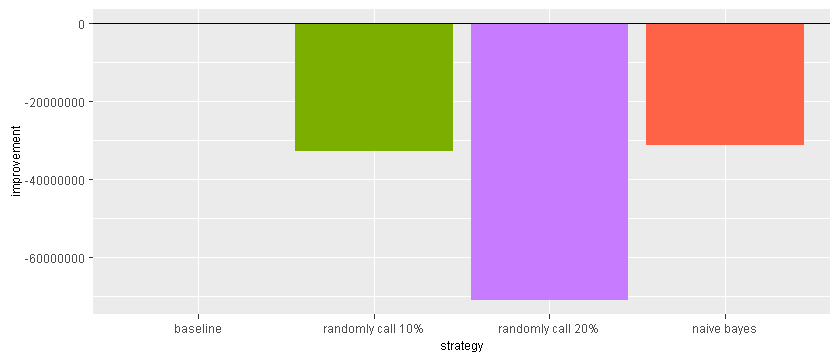

In [37]:
ggplot(report) + xlab("strategy") +
geom_col(aes(x=factor(strategy, strategy), y=improvement, fill=strategy)) + 
geom_hline(yintercept=0) +
scale_fill_manual(values=PALETTE) + theme.no_legend

In [38]:
profit.next_best_strategy = max(report$profit[1:3])
business_value = profit.nb - profit.next_best_strategy

data.frame(save_rate, intervention_cost, business_value)

save_rate,intervention_cost,business_value
0.25,500,-31350582


## Discussion

* Why unbalance the data?
* How much is the naive Bayes model worth?
* How much is training intervention agents worth?
* How much is reducing intervention agent costs worth?
* What effect does growth have on how much the naive Bayes model is worth?
* What insights do you get from accuracy measures, confusion matrix measures, and business value measures?

## Further Reading

* https://www.researchgate.net/publication/320331663_MCS_Multiple_Classifier_System_to_Predict_the_Churners_in_the_Telecom_Industry

<font size=1;>
<p style="text-align: left;">
Copyright (c) Berkeley Data Analytics Group, LLC
<span style="float: right;">
Document revised March 8, 2020
</span>
</p>
</font>